In [1]:
# import modules
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import numpy as np

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.feature_selection import RFECV

In [2]:
# load data
df = pickle.load(open('data/abc_classification_modeling.p', 'rb')) # rb is reading
df.head()

,customer_id,signup_flag,distance_from_store,gender,credit_score,total_sales,total_items,transaction_count,product_area_count,average_basket_value
0,74,1,3.38,F,0.59,1586.89,195,26,5,61.034231
1,524,1,4.76,F,0.52,2397.26,258,27,5,88.787407
2,607,1,4.45,F,0.49,1279.91,183,22,5,58.177727
3,343,0,0.91,M,0.54,967.14,102,17,5,56.890588
4,322,1,3.02,F,0.63,1566.35,182,30,5,52.211667


In [3]:
# shuffle data
df = shuffle(df)

In [4]:
# drop unecessary columns
df.drop('customer_id', axis = 1, inplace = True)

In [5]:
# class balance (proportion of 1s and 0s we're predicting for)
df['signup_flag'].value_counts(normalize = True) # normalize outputs the percentages

0    0.689535
1    0.310465
Name: signup_flag, dtype: float64

In [6]:
# deal with missing value
print(df.isna().sum()) # count of na values
df.dropna(how = 'any', inplace = True) # we don't need to use imputer in this case since we have a very small amount of na records

signup_flag             0
distance_from_store     5
gender                  5
credit_score            8
total_sales             0
total_items             0
transaction_count       0
product_area_count      0
average_basket_value    0
dtype: int64


In [7]:
# identify outliers (exploration)
df_description = df.describe()
df_description # distance_from_store, total_sales, and total_items seem to have outliers


,signup_flag,distance_from_store,credit_score,total_sales,total_items,transaction_count,product_area_count,average_basket_value
count,847.000000,847.000000,847.000000,847.000000,847.000000,847.000000,847.000000,847.000000
mean,0.304604,2.614545,0.597521,968.166411,143.877214,22.214876,4.177096,38.034161
std,0.460512,14.397590,0.102264,1073.647531,125.342694,11.721699,0.920887,24.243691
min,0.000000,0.000000,0.260000,2.090000,1.000000,1.000000,1.000000,2.090000
25%,0.000000,0.730000,0.530000,383.940000,77.000000,16.000000,4.000000,21.734700
50%,0.000000,1.640000,0.590000,691.640000,123.000000,23.000000,4.000000,31.069333
75%,1.000000,2.920000,0.670000,1121.530000,170.500000,28.000000,5.000000,46.429973
max,1.000000,400.970000,0.880000,7372.060000,910.000000,75.000000,5.000000,141.054091


In [8]:
# deal with outliers using the boxplot approach
outlier_columns = [
    'distance_from_store', 
    'total_sales', 
    'total_items'
]

for col in outlier_columns:
    # calculate lower and upper quartiles
    lower_quartile = df[col].quantile(0.25)
    upper_quartile = df[col].quantile(0.75)

    # caluclate interquartile range
    iqr = upper_quartile - lower_quartile

    # calucalte extended interquartile range using a factor of 2
    iqr_extended = iqr * 2

    # calcualte max and min borders using extended iqr (these are the vertical ticks outside the boxplot)
    max_border = upper_quartile + iqr_extended
    min_border = lower_quartile - iqr_extended

    # return index value for outliers
    outliers = df[(df[col] < min_border) | (df[col] > max_border)].index 

    # print results
    print(f'Column [{col}]: Removed {len(outliers)} Outliers. \n \t Index: {outliers}')

    # remove outliers
    df.drop(outliers, inplace = True)

Column [distance_from_store]: Removed 8 Outliers. 
 	 Index: Int64Index([35, 792, 850, 722, 613, 8, 197, 730], dtype='int64')
Column [total_sales]: Removed 54 Outliers. 
 	 Index: Int64Index([805, 770,  94, 787, 840, 815,  34, 809, 795, 776, 794, 803, 789,
            802, 820, 777, 832, 779, 793, 785, 778, 800, 790, 782, 808,  24,
             20, 780,   6, 801, 816, 804, 773, 806, 822, 771, 842, 798, 807,
            854, 791, 206,  69, 799, 841, 788, 772, 205, 796, 846, 797, 786,
            783, 775],
           dtype='int64')
Column [total_items]: Removed 3 Outliers. 
 	 Index: Int64Index([68, 774, 781], dtype='int64')


In [9]:
# split input and output variables
X = df.drop(['signup_flag'], axis = 1) # input vairables
y = df['signup_flag'] # output variable

In [10]:
# split data into training and test sets
# stratify to ensure same proportion of classes
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y) 

In [11]:
# deal with categorical variables
categorical_vars = ['gender']

# enstantiate one hot encoder object and apply to training and test data
one_hot_encoder = OneHotEncoder(sparse = False, drop = 'first') # returns array, drops one of the binary categorical columns to reduce multicollinearity

X_train_encoded = one_hot_encoder.fit_transform(X_train[categorical_vars])
X_test_encoded = one_hot_encoder.transform(X_test[categorical_vars])

# create object to get feature names
encoder_feature_names = one_hot_encoder.get_feature_names_out(categorical_vars)

# create data frame with encoder variables and feature names, and concat to original data frame and reset index
X_train_encoded = pd.DataFrame(X_train_encoded, columns = encoder_feature_names)
X_train = pd.concat([X_train.reset_index (drop = True), X_train_encoded.reset_index (drop = True)], axis = 1) # axis 1 concats columns and not rows
X_train.drop(categorical_vars, axis = 1, inplace = True) # axis 1 drops columns and not rows

X_test_encoded = pd.DataFrame(X_test_encoded, columns = encoder_feature_names)
X_test = pd.concat([X_test.reset_index (drop = True), X_test_encoded.reset_index (drop = True)], axis = 1) # axis 1 concats columns and not rows
X_test.drop(categorical_vars, axis = 1, inplace = True) # axis 1 drops columns and not rows

In [12]:
# feature scaling (normalization)
scale_norm = MinMaxScaler()
X_train = pd.DataFrame(scale_norm.fit_transform(X_train), columns = X_train.columns)
X_test = pd.DataFrame(scale_norm.transform(X_test), columns = X_test.columns)

X_train.head()

,distance_from_store,credit_score,total_sales,total_items,transaction_count,product_area_count,average_basket_value,gender_M
0,0.513185,0.612903,0.116400,0.186120,0.243902,0.75,0.218423,0.0
1,0.202840,0.661290,0.472614,0.634069,0.756098,0.75,0.310405,0.0
2,0.133874,0.951613,0.039015,0.082019,0.170732,0.75,0.092232,1.0
3,0.292089,0.467742,0.368345,0.454259,0.634146,1.00,0.285464,1.0
4,0.182556,0.403226,0.033443,0.078864,0.073171,0.50,0.171988,1.0


Optimal Number of Features: 6 



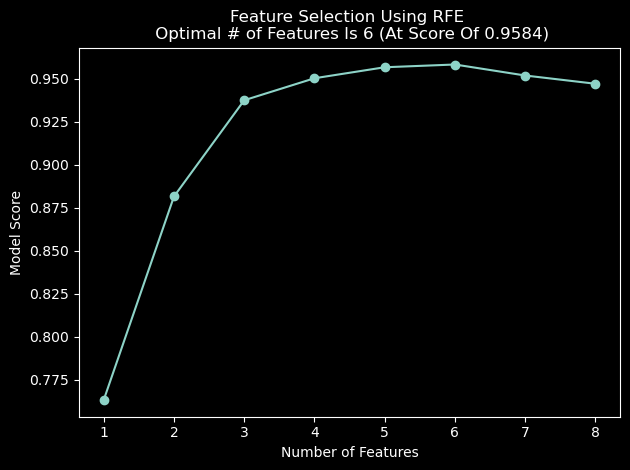

In [13]:
# feature selection

# instantiate regression and feature selecter object
clf = RandomForestClassifier()
feature_selector = RFECV(clf)

# learn relationships
fit = feature_selector.fit(X_train, y_train)

# determine optimal number of features based on cross validation
optimal_feature_count = feature_selector.n_features_
print(f'Optimal Number of Features: {optimal_feature_count} \n')

# create new dataframe with selected features
X_train = X_train.loc[:, feature_selector.get_support()]
X_test = X_test.loc[:, feature_selector.get_support()]

# plot results to visually determine best number of features
plt.plot(range(1, len(fit.cv_results_['mean_test_score']) + 1), fit.cv_results_['mean_test_score'], marker = "o")
plt.ylabel("Model Score")
plt.xlabel("Number of Features")
plt.title(f"Feature Selection Using RFE \n Optimal # of Features Is {optimal_feature_count} (At Score Of {round(max(fit.cv_results_['mean_test_score']),4)})")
plt.tight_layout()
plt.show()

In [14]:
# train model
clf = KNeighborsClassifier()
clf.fit(X_train, y_train)

KNeighborsClassifier()

In [ ]:
# assess model accuracy
y_pred_class = clf.predict(X_test)
y_pred_prob = clf.predict_proba(X_test)[:,1]

In [16]:
# create confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_class)
print(conf_matrix)

[[111   4]
 [  8  34]]


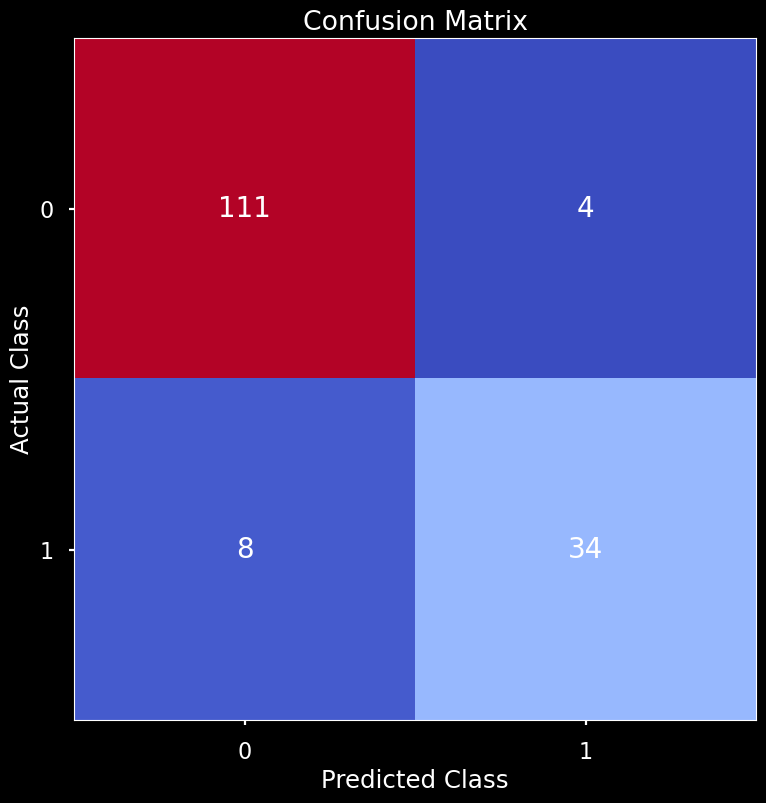

In [17]:
# plot confusion matrix
plt.style.use('seaborn-poster')
plt.matshow(conf_matrix, cmap = 'coolwarm')
plt.gca().xaxis.tick_bottom()
plt.title('Confusion Matrix')
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')

for (i, j), corr_value in np.ndenumerate(conf_matrix):
    plt.text(j, i, corr_value, ha = 'center', va = 'center', fontsize = 20)

plt.show()

In [18]:
# accuracy score (number of correct classification out of all attempted classifications)
accuracy = accuracy_score(y_test, y_pred_class)
print(f'Accuracy Score: {accuracy}')

Accuracy Score: 0.9235668789808917


In [19]:
# precision score (of all observations predicted positive, how many were actually positive)
precision = precision_score(y_test, y_pred_class)
print(f'Precision Score: {precision}')

Precision Score: 0.8947368421052632


In [20]:
# recall score (of all positive observations, how many were predicted as positive)
recall = recall_score(y_test, y_pred_class)
print(f'Recall Score: {recall}')

Recall Score: 0.8095238095238095


In [21]:
# F1-Score (harmonic mean of precision and recall) (useful for imbalanced data)
f1 = f1_score(y_test, y_pred_class)
print(f'F1-Score: {f1}')

F1-Score: 0.8500000000000001


In [ ]:
# finding optimal value for k
k_list = list(range(2, 25))
accuracy_scores_f1 = []

for k in k_list:
    clf = KNeighborsClassifier(n_neighbors = k)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    accuracy_f1 = f1_score(y_test, y_pred)
    accuracy_scores_f1.append(accuracy_f1)

In [23]:
# display dictionary of accuracy score for each tested k-value
accuracy_scores_f1_dict = {}
range_index = 2

for score in accuracy_scores_f1:
    accuracy_scores_f1_dict.update({
        f'K-Value = {range_index}': round(score, 4)
    })

    range_index += 1

accuracy_scores_f1_dict

{'K-Value = 2': 0.8462,
 'K-Value = 3': 0.8434,
 'K-Value = 4': 0.8571,
 'K-Value = 5': 0.85,
 'K-Value = 6': 0.8267,
 'K-Value = 7': 0.8312,
 'K-Value = 8': 0.8267,
 'K-Value = 9': 0.8462,
 'K-Value = 10': 0.8533,
 'K-Value = 11': 0.8462,
 'K-Value = 12': 0.8,
 'K-Value = 13': 0.8,
 'K-Value = 14': 0.8,
 'K-Value = 15': 0.8158,
 'K-Value = 16': 0.8,
 'K-Value = 17': 0.8158,
 'K-Value = 18': 0.8108,
 'K-Value = 19': 0.8108,
 'K-Value = 20': 0.7778,
 'K-Value = 21': 0.8267,
 'K-Value = 22': 0.7778,
 'K-Value = 23': 0.7671,
 'K-Value = 24': 0.7606}

In [24]:
# determine max accuracy and optimal depth
max_accuracy = max(accuracy_scores_f1)
max_accuracy_idx = accuracy_scores_f1.index(max_accuracy)
optimal_k_value = k_list[max_accuracy_idx]

print(f'The Optimal K-Value is: {optimal_k_value}')

The Optimal K-Value is: 4


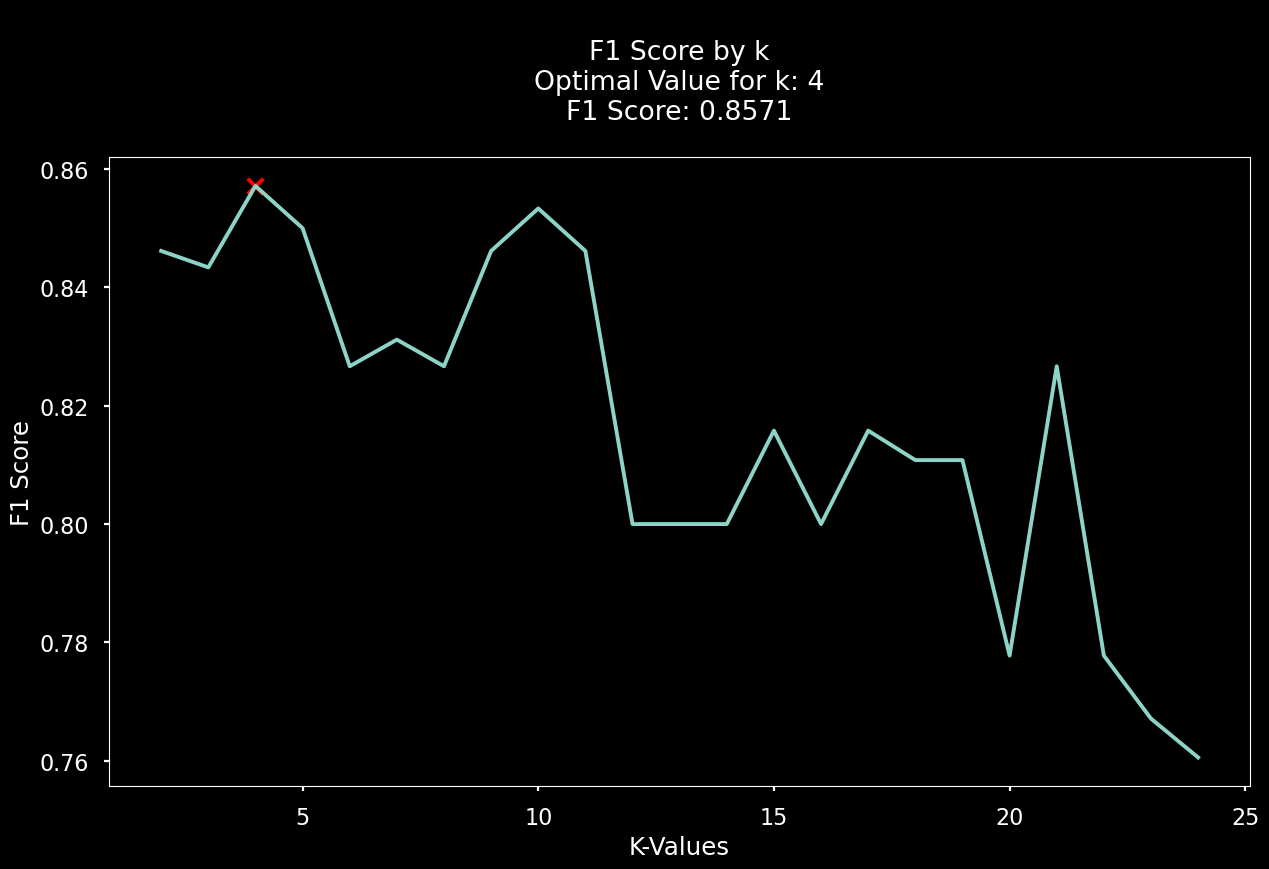

In [25]:
# plot of max depths
plt.plot(k_list, accuracy_scores_f1)
plt.scatter(optimal_k_value, max_accuracy, marker = 'x', color = 'red')

plt.title(f'''
F1 Score by k
Optimal Value for k: {optimal_k_value}
F1 Score: {round(max_accuracy, 4)}
''')

plt.xlabel('K-Values')
plt.ylabel('F1 Score')

plt.tight_layout()
plt.show()

In [26]:
# re-train model with optimal value for k
clf = KNeighborsClassifier(n_neighbors = optimal_k_value)
clf.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=4)

In [ ]:
# assess model accuracy
y_pred_class = clf.predict(X_test)
y_pred_prob = clf.predict_proba(X_test)[:,1]

In [28]:
# create confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_class)
print(conf_matrix)

[[113   2]
 [  9  33]]


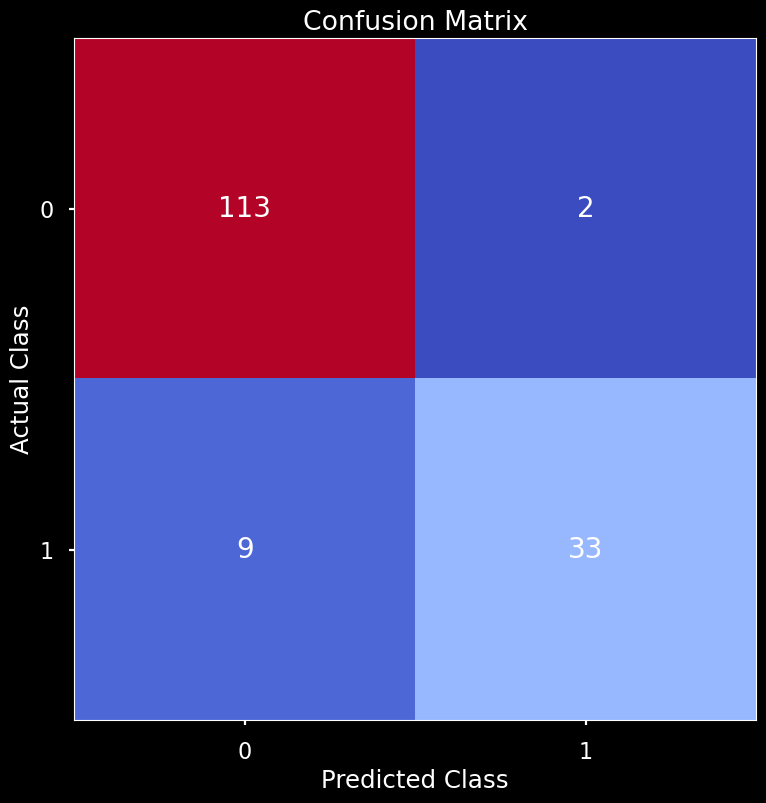

In [29]:
# plot confusion matrix
plt.style.use('seaborn-poster')
plt.matshow(conf_matrix, cmap = 'coolwarm')
plt.gca().xaxis.tick_bottom()
plt.title('Confusion Matrix')
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')

for (i, j), corr_value in np.ndenumerate(conf_matrix):
    plt.text(j, i, corr_value, ha = 'center', va = 'center', fontsize = 20)

plt.show()

In [30]:
# accuracy score (number of correct classification out of all attempted classifications)
accuracy = accuracy_score(y_test, y_pred_class)
print(f'Accuracy Score: {accuracy}')

Accuracy Score: 0.9299363057324841


In [31]:
# precision score (of all observations predicted positive, how many were actually positive)
precision = precision_score(y_test, y_pred_class)
print(f'Precision Score: {precision}')

Precision Score: 0.9428571428571428


In [32]:
# recall score (of all positive observations, how many were predicted as positive)
recall = recall_score(y_test, y_pred_class)
print(f'Recall Score: {recall}')

Recall Score: 0.7857142857142857


In [33]:
# F1-Score (harmonic mean of precision and recall) (useful for imbalanced data)
f1 = f1_score(y_test, y_pred_class)
print(f'F1-Score: {f1}')

F1-Score: 0.8571428571428571
